# Background Knowledge

## Variational Inference


Objective: Learn a parameterized distribution $q_{\theta}(y)$ to approximate the true posterior via minimizing the KL-divergence, making it as close to the true posterior $p(y|x)$ as possible. 


$$KL(q_{\theta}(y)||p(y|x)) = E_q[\log \frac{q_{\theta}(y)}{p(y|x)}]$$

$$E_q[\log \frac{q_{\theta}(y)}{p(y|x)}] = E_q[\log q_{\theta}(y)] - E_q[\log \frac{p(x|y)p(y)}{p(x)}]$$

$${\color{blue}{\log p(x)}} - KL(q_{\theta}(y)||p(y|x)) = {\color{red}{E_q[\log p(x|y)] + E_q[\log \frac{p(y)}{q_{\theta}(y)}]}}$$


Where the blue part is fixed once the dataset is fixed and maximazing the red part is equivalently minimizing the KL divergence between the parmeterized distribution and the true posterior. 


In [20]:
################
# library import
################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow_probability as tfp
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import seaborn as sns
sns.reset_defaults()

tfd = tfp.distributions
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline

## Linear Regression with noise having universal standard deviations

Here we consider the following linear regression model:
$$y = ax + b +\epsilon, \ \epsilon \sim N(0, \sigma^2_\epsilon)$$

In this problem where the true model is linear, we know that the optimal linear unbiased estimator is least square estimator. 
The problem is defined as below:

$$\min_{a,b} || ax+b - y ||^2 = max_{a,b} p(y|x; a,b)$$
$$p(y|x; a,b) \sim N(ax+b, \sigma^2_\epsilon) = \frac{1}{\text{constant}}\exp(-\frac{1}{2\sigma^2_\epsilon}(ax+b-y)^2))$$

In [21]:
#################
# hyperparameters
#################
'''
a: interscept
b: slope
x_low: minimum value of x for data generation
x_high: maximum value of x for data generation
std: standard deviation of noise
n_train: # of samples for trianing
n_test: # of samples for testing
'''

a = 0.125
b = 1.
x_low = -20.
x_high = 60.
std = 1.
n_train = 200
n_test = 200

In [22]:
###################################################
# define plotting function and dataset generator
###################################################

def load_dataset_universal(n=150, n_test=150, std=1.):
    '''
    generate samples for a given training dataset and testing dataset and variance for additive Gaussian noise
    n: # of samples for trianing
    n_test: # of samples for testing
    std: noise standard deviation
    '''
    x_train = np.random.uniform(x_low, x_high, n)
    x_test = np.random.uniform(x_low, x_high, n_test)
    
    y_train, y_test = a*x_train + b + np.random.randn(n) * std, a*x_test + b + np.random.randn(n) * std
    
    return x_train, x_test, y_train, y_test


def plotting(x, y, xtest, ytest):
    '''
    plotting function
    x: inputs
    y: responses following the linear model
    xtest: inputs for testing
    ytest: responses for testing
    '''
    plt.figure(figsize=[8, 5.5])  # inches
    #plt.figure(figsize=[8, 5])  # inches
    plt.plot(x, y, 'b.', label='observed')
    plt.plot(xtest, ytest,'r', label='groundtruth', linewidth=4)
    plt.ylim(-0.,17)
    plt.yticks(np.linspace(min(y)-5., max(y)+5., 5)[1:])
    plt.xticks(np.linspace(x_low, x_high, num=9))

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=16)


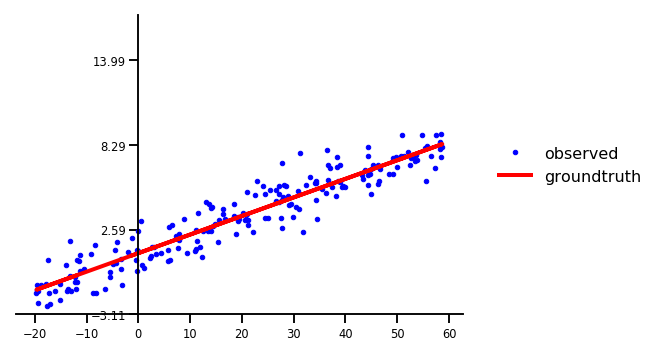

In [23]:
##############################
# groundtruth vs observations
##############################

x, x_tst, y, y_tst = load_dataset_universal(n_train, n_test, std)
plotting(x, y, x, x*a + b)

In [24]:
# optimize with TF library

# Build model

'''
Define the model with tf.keras library
'''

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# model fitting
'''
Define loss as negative log likelihood
Here we minimize negative loglikelihood to equivalently maximazing the loglikelihood
'''
negative_log_likelihood = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negative_log_likelihood)
model.fit(x[...,np.newaxis], y, epochs=1000, verbose=False)

# inference
slope, bias = [np.squeeze(w.numpy()) for w in model.weights]
print('#'*50)
print("slope: {}".format(slope))
print("bias: {}".format(bias))
print("true slope: {}".format(a))
print("true bias: {}".format(b))
print('#'*50)
yhat = model(x_tst.astype(np.float32)[..., np.newaxis])


##################################################
slope: 0.126823067665
bias: 0.945205271244
true slope: 0.125
true bias: 1.0
##################################################


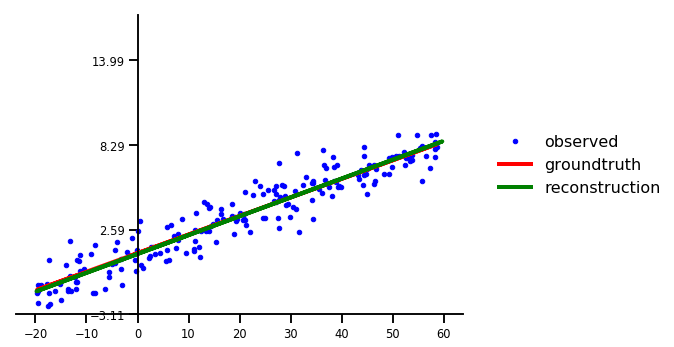

In [25]:
def plotting1(x, y, xt, yt, xtest, ytest):
    '''
    plotting data points, ture model and learned model
    (x, y): points in the dataset
    (xt, yt): ground truth points without error
    (xtest, ytest): points from learned linear model
    '''
    plt.figure(figsize=[8, 5.5])  # inches
    plt.plot(x, y, 'b.', label='observed')
    plt.plot(xt, yt,'r', label='groundtruth', linewidth=4)
    plt.plot(xtest, ytest,'g', label='reconstruction', linewidth=4)
    plt.ylim(-0.,17)
    plt.yticks(np.linspace(min(y)-5., max(y)+5., 5)[1:])
    plt.xticks(np.linspace(x_low, x_high, num=9))

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=16)

plotting1(x, y, x, x*a + b, x_tst, np.squeeze(yhat.mean()))

# Aleatoric Uncertanty (noise uncertainty)
In the case where a universal noise is unrealistic (the noise variance depends on the value of the input x), we can change the above model to the following:
$$y = ax + b + \epsilon(x)$$

As a result, the problem is slightly changed to:
$$max_{a,b, \theta} p(y|x; a,b, \theta)$$
$$p(y|x; a,b, \theta) \sim N(ax+b, \sigma^2
_{\epsilon_{\theta}(x)})$$

In [26]:
#################
# hyperparameters
#################
'''
a: interscept
b: slope
x_low: minimum value of x for data generation
x_high: maximum value of x for data generation
std: standard deviation of noise
n_train: # of samples for trianing
n_test: # of samples for testing
'''

a = 0.125
b = 1.
x_low = -20.
x_high = 60.
std = 1.
n_train = 200
n_test = 200

###################################################
# define plotting function and dataset generator
###################################################

def load_dataset_aleatoric(n=150, n_test=150, std=1.):
    '''
    generate samples for a given training dataset and testing dataset and variance for additive Gaussian noise
    '''
    x_train = np.random.uniform(x_low, x_high, n)
    x_test = np.random.uniform(x_low, x_high, n_test)
    def s(x):
        g = (x - min(x)) / (max(x) - min(x))
        return 3 * (0.25 + g**2.)
    adjust_std1 = s(x_train)
    adjust_std2 = s(x_test)
    #print(np.random.randn(n) * adjust_std1)
    y_train, y_test = a*x_train + b + np.random.randn(n) * adjust_std1, a*x_test + b + np.random.randn(n) * adjust_std2
    
    return x_train, x_test, y_train, y_test

def plotting(x, y, xtest, ytest):
    '''
    (x, y): points in the dataset
    (xt, yt): ground truth points without error
    '''
    plt.figure(figsize=[8, 5.5])  # inches
    #plt.figure(figsize=[8, 5])  # inches
    plt.plot(x, y, 'b.', label='observed')
    plt.plot(xtest, ytest,'r', label='groundtruth', linewidth=4)
    plt.ylim(-0.,17)
    plt.yticks(np.linspace(min(y)-5., max(y)+5., 5)[1:])
    plt.xticks(np.linspace(x_low, x_high, num=9))

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=16)

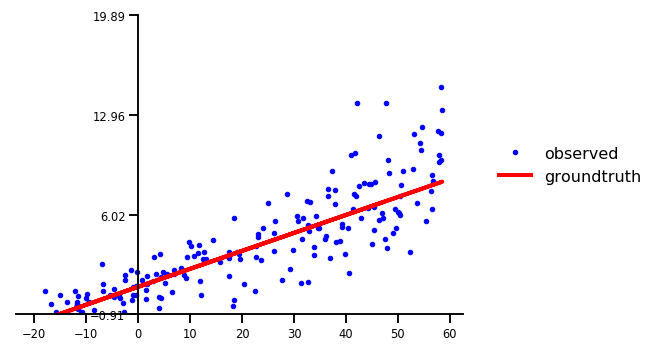

In [27]:
# groundtruth vs observations
x, x_tst, y, y_tst = load_dataset_aleatoric(n_train, n_test, std)
plotting(x, y, x, x*a + b)

In [28]:
# Build model.

'''
Define the model with tf.keras library
'''

model = tf.keras.Sequential([
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
'''
Define loss as negative log likelihood
Here we minimize negative loglikelihood to equivalently maximazing the loglikelihood
'''

negative_log_likelihood = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negative_log_likelihood)
model.fit(x[...,np.newaxis], y, epochs=1000, verbose=False)

# Results.
slope, bias = [np.squeeze(w.numpy()) for w in model.weights]
print('#'*50)
print("slope: {}, std: {}".format(slope[0], slope[1]))
print("bias: {}, std: {}".format(bias[0], bias[1]))
print("true slope: {}".format(a))
print("true bias: {}".format(b))
yhat = model(x_tst[..., np.newaxis])
print('#'*50)
assert isinstance(yhat, tfd.Distribution)

##################################################
slope: 0.130512818694, std: 0.764075577259
bias: 0.999279141426, std: 9.82911109924
true slope: 0.125
true bias: 1.0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

##################################################


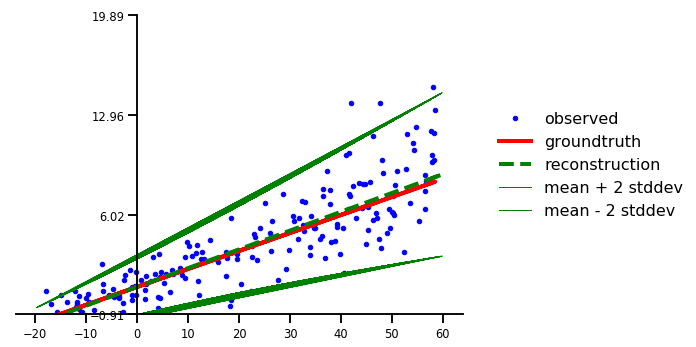

In [29]:
def plotting2(x, y, xt, yt, xtest, ytest_mean, ytest_std):
    '''
    plotting data points, ture model and learned model with uncertainty boundries
    (x, y): points in the dataset
    (xt, yt): ground truth points without error
    (xtest, ytest): points from learned linear model
    (ytest_mean, ytest_std): means and stds for every points output from the learned model
    '''
    plt.figure(figsize=[8, 5.5])  
    plt.plot(x, y, 'b.', label='observed')
    plt.plot(xt, yt,'r', label='groundtruth', linewidth=4)
    plt.plot(xtest, ytest_mean,'g', label='reconstruction', linewidth=4, linestyle='dashed')
    plt.plot(xtest, ytest_mean + 2.*ytest_std,'g', label=r'mean + 2 stddev', linewidth=1)
    plt.plot(xtest, ytest_mean - 2.*ytest_std,'g', label=r'mean - 2 stddev', linewidth=1)
    plt.ylim(-0.,17)
    plt.yticks(np.linspace(min(y)-5., max(y)+5., 5)[1:])
    plt.xticks(np.linspace(x_low, x_high, num=9))

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=16)

plotting2(x, y, x, x*a + b, x_tst, np.squeeze(yhat.mean()), np.squeeze(yhat.stddev()))

# Epistemic Uncertainty (model uncertainty)

Now we move forward to another type of uncertainty--model uncertainty. The model uncertainty introduced by different data, model initializaiton, etc.

Consider the objectives for this problem and the previous problems:

Linear regression with universal uncertainty: $max_{a,b} \color{red}{p(y|x; a,b)}$

Linear regression with data dependent uncertainty: $max_{a,b, \theta} \color{red}{p(y|x; a,b, \theta)}$

Linear regression with model uncertainty:
$$max_{\theta, w} p(y|x; \theta, w)$$
$$p(y|x; \theta, w) = \int_{a, b}{\color{red}{p(y| a,b, x; \theta)}} {\color{blue}{p_w(a, b | x)}} da db$$


The red terms are similar across different objectives. The blue term, which is parameterized by $w$, is a posterior on the model parameters. The posterior can be learned trhough variational inference, as is shown at the begning of the notebook.

In [30]:
#################
# hyperparameters
#################
'''
a: interscept
b: slope
x_low: minimum value of x for data generation
x_high: maximum value of x for data generation
std: standard deviation of noise
n_train: # of samples for trianing
n_test: # of samples for testing
'''

a = 0.125
b = 1.
x_low = -20.
x_high = 60.
std = 2.
n_train = 200
n_test = 200

###################################################
# define plotting function and dataset generator
###################################################

def load_dataset_epistemic(n=150, n_test=150, std=1.):
    '''
    generate samples for a given training dataset and testing dataset and variance for additive Gaussian noise
    '''
    x_train = np.random.uniform(x_low, x_high, n)
    x_test = np.random.uniform(x_low, x_high, n_test)
    def s(x):
        g = (x - min(x)) / (max(x) - min(x))
        return 3 * (0.25 + g**2.)
    adjust_std1 = s(x_train)
    adjust_std2 = s(x_test)
    #print(np.random.randn(n) * adjust_std1)
    y_train, y_test = a*x_train + b + np.random.randn(n) * adjust_std1, a*x_test + b + np.random.randn(n) * adjust_std2
    
    return x_train, x_test, y_train, y_test

def plotting(x, y, xtest, ytest):
    '''
    (x, y): points in the dataset
    (xt, yt): ground truth points without error
    '''
    plt.figure(figsize=[8, 5.5])  # inches
    #plt.figure(figsize=[8, 5])  # inches
    plt.plot(x, y, 'b.', label='observed')
    plt.plot(xtest, ytest,'r', label='groundtruth', linewidth=4)
    plt.ylim(-0.,17)
    plt.yticks(np.linspace(min(y)-5., max(y)+5., 5)[1:])
    plt.xticks(np.linspace(x_low, x_high, num=9))

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=16)

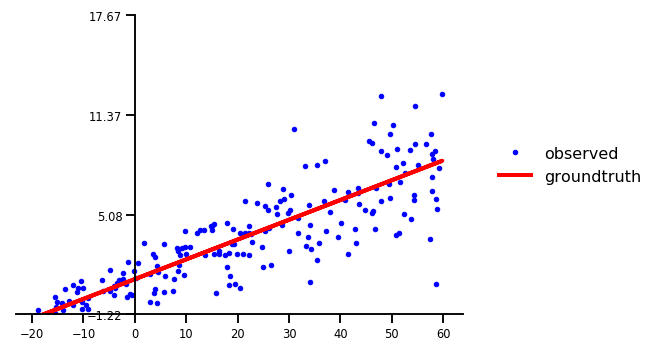

In [31]:
# groundtruth vs observations
x, x_tst, y, y_tst = load_dataset_epistemic(n_train, n_test, std)
plotting(x, y, x, x*a + b)

In [32]:
# optimize with TF library
# Build model

'''
Define the model with tf.keras library
'''

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
                                tfp.layers.VariableLayer(2 * n, dtype=dtype), 
                                tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                                                              tfd.Normal(loc=t[..., :n],
                                                              scale=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t[..., n:])),
                                                              reinterpreted_batch_ndims=1)),
                               ])

def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
                                tfp.layers.VariableLayer(n, dtype=dtype),
                                tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                                                              tfd.Normal(loc=t, scale=1),
                                                              reinterpreted_batch_ndims=1)),
                              ])


model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior, kl_weight=1./n_train),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# model fitting
'''
Define loss as negative log likelihood
Here we minimize negative loglikelihood to equivalently maximazing the loglikelihood
'''
negative_log_likelihood = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negative_log_likelihood)
model.fit(x[...,np.newaxis], y, epochs=1000, verbose=False)

# inference
tmp_out = [np.squeeze(w.numpy()) for w in model.weights]
print(tmp_out)
slope, bias = tmp_out[0][0], tmp_out[0][1]
print('#'*50)
print("slope: {}".format(slope))
print("bias: {}".format(bias))
print("true slope: {}".format(a))
print("true bias: {}".format(b))
print('#'*50)
yhat = model(x_tst.astype(np.float32)[..., np.newaxis])



[array([ 0.12057224,  0.98071253, -4.5000806 , -2.7922115 ], dtype=float32), array([0.12894632, 0.978977  ], dtype=float32)]
##################################################
slope: 0.120572239161
bias: 0.980712532997
true slope: 0.125
true bias: 1.0
##################################################



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



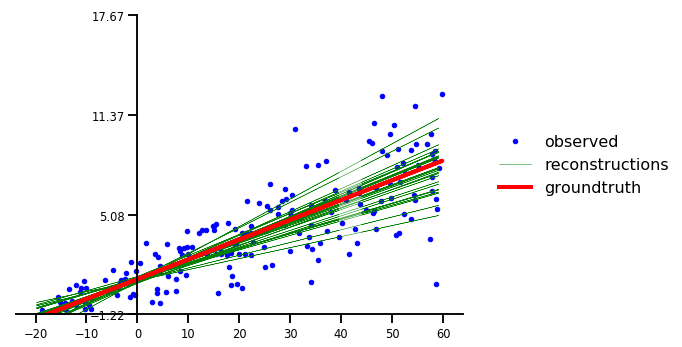

In [33]:
yhats_list = [model(x_tst[..., np.newaxis]) for _ in range(30)]

def plotting3(x, y, xt, yt, xtest, yhats_list):
    '''
    plotting data points, ture model and learned model under considerations of the model uncertainty
    (x, y): points in the dataset
    (xt, yt): ground truth points without error
    xtest: test input points
    yhats_list: given xtest as inputs, the variantions of the ys, currently for every point of xtest, 
    there are 30 different output values measuring the model uncertainty.
    '''
    
    plt.figure(figsize=[8, 5.5])  
    plt.plot(x, y, 'b.', label='observed')
    
    for i, yhats in enumerate(yhats_list):
        plt.plot(x_tst, np.squeeze(yhats.mean()), 'g', label='reconstructions' if i == 0 else None, linewidth=0.5)
    plt.plot(xt, yt,'r', label='groundtruth', linewidth=4)
    plt.ylim(-0.,17)
    plt.yticks(np.linspace(min(y)-5., max(y)+5., 5)[1:])
    plt.xticks(np.linspace(x_low, x_high, num=9))

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=16)

plotting3(x, y, x, x*a + b, x_tst, yhats_list)